## plot the result to inspect

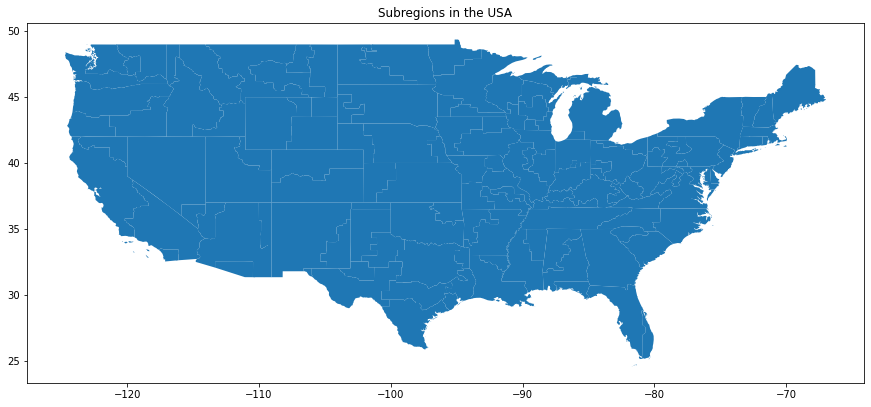

In [8]:
import pandas as pd
import plotly.graph_objects as go
import geopandas as gpd
import matplotlib.pyplot as plt 
# Load the polygon data
polygons_gdf = pd.read_csv('/Users/ansonkong/Downloads/NYU_work_repo/resources/US_CAN_MEX_PCA_polygons.csv')

# Filter the GeoDataFrame to keep only the specified 'rb' values
polygons_gdf_filtered = polygons_gdf[polygons_gdf['rb'].isin([f'p{i}' for i in range(1, 135)])]

# Convert WKT to a GeoDataFrame for easier plotting
polygons_gdf_filtered = gpd.GeoDataFrame(polygons_gdf_filtered, geometry=gpd.GeoSeries.from_wkt(polygons_gdf_filtered['WKT']))

# Plotting using GeoPandas
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
polygons_gdf_filtered.plot(ax=ax)

# Setting up the plot details
ax.set_title("Subregions in the USA")
plt.show()


In [ ]:
import dash
from dash import html, dcc
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import geopandas as gpd
import pandas as pd
import plotly.express as px
import json
import numpy as np
import os
from shapely.geometry import Point
from shapely import wkt
# Process the 'reeds_ba_list' column to expand the sets into individual rows, keeping 'state' intact
from ast import literal_eval
# Get the current directory where your script is running
current_directory = os.getcwd()

# Construct the path to your resources folder dynamically
resources_path = os.path.join(current_directory, 'resources')

# Now, build the full path to your CSV files
polygons_csv_path = os.path.join(resources_path, 'US_CAN_MEX_PCA_polygons.csv')
state_to_ba_csv_path = os.path.join(resources_path, 'state_to_ba_mapping.csv')
# Finally, use pandas to read the CSV files
polygons_df = pd.read_csv(polygons_csv_path)
state_to_ba_df = pd.read_csv(state_to_ba_csv_path)
# Filter polygons
polygons_df = polygons_df[polygons_df['rb'].isin([f'p{i}' for i in range(1, 135)])]

# Since the instructions for processing the state mapping are a bit unclear,
# Convert the string representation of sets in 'reeds_ba_list' to actual sets
state_to_ba_df['reeds_ba_list'] = state_to_ba_df['reeds_ba_list'].apply(literal_eval)

# Explode the sets into separate rows
exploded_df = state_to_ba_df.explode('reeds_ba_list')[['state','reeds_ba_list']]
polygons_df_filtered = polygons_df[polygons_df['rb'].isin([f'p{i}' for i in range(1, 135)])]
polygons_gdf = gpd.GeoDataFrame(polygons_df_filtered, geometry=gpd.GeoSeries.from_wkt(polygons_df_filtered['WKT']))

# Step 2: Merge exploded_df with polygons_gdf on the 'reeds_ba_list' and 'rb' columns
merged_gdf = polygons_gdf.merge(exploded_df, left_on='rb', right_on='reeds_ba_list')
merged_gdf['country']='USA'
merged_gdf=merged_gdf[['rb','state','country','geometry']]

# Country - Group by 'country' and dissolve to merge geometries
gdf_country = merged_gdf.dissolve(by='country').reset_index()

# State - Group by 'state' and dissolve to merge geometries
gdf_state = merged_gdf.dissolve(by='state').reset_index()

# Subregion (rb) - No need to group since each 'rb' is already unique
gdf_subregion = merged_gdf[['rb', 'geometry']].drop_duplicates()


# Convert each GeoDataFrame to GeoJSON for use in Plotly
geojson_country = json.loads(gdf_country.to_json())
geojson_state = json.loads(gdf_state.to_json())
geojson_subregion = json.loads(gdf_subregion.to_json())
import json
current_directory= os.path.join(current_directory, 'web_page_data')
# Define file paths for saving
geojson_country_path = os.path.join(current_directory, 'geojson_country.json')
geojson_state_path = os.path.join(current_directory, 'geojson_state.json')
geojson_subregion_path = os.path.join(current_directory, 'geojson_subregion.json')
# Define file paths for saving
gdf_country_path = os.path.join(current_directory, 'gdf_country.gpkg')
gdf_state_path = os.path.join(current_directory, 'gdf_state.gpkg')
gdf_subregion_path = os.path.join(current_directory, 'gdf_subregion.gpkg')

# Save the GeoDataFrames
gdf_country.to_file(gdf_country_path, driver='GPKG')
gdf_state.to_file(gdf_state_path, driver='GPKG')
gdf_subregion.to_file(gdf_subregion_path, driver='GPKG')

# Function to save GeoJSON to a file
def save_geojson(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f)

# Save the GeoJSON data
save_geojson(geojson_country, geojson_country_path)
save_geojson(geojson_state, geojson_state_path)
save_geojson(geojson_subregion, geojson_subregion_path)


In [ ]:
# Function to read GeoJSON from a file
def read_geojson(file_path):
    with open(file_path) as f:
        return json.load(f)

# Read the GeoJSON data
geojson_country_read = read_geojson(geojson_country_path)
geojson_state_read = read_geojson(geojson_state_path)
geojson_subregion_read = read_geojson(geojson_subregion_path)


In [ ]:
print(geojson_country == geojson_country_read)
print(geojson_state == geojson_state_read)
print(geojson_subregion == geojson_subregion_read)


In [ ]:
# Read the GeoDataFrames
gdf_country_read = gpd.read_file(gdf_country_path)
gdf_state_read = gpd.read_file(gdf_state_path)
gdf_subregion_read = gpd.read_file(gdf_subregion_path)


In [ ]:
print(gdf_country.shape == gdf_country_read.shape)
print(gdf_state.shape == gdf_state_read.shape)
print(gdf_subregion.shape == gdf_subregion_read.shape)

# Sample a row and compare geometries (example using 'gdf_country')
print(gdf_country.geometry.iloc[0].equals(gdf_country_read.geometry.iloc[0]))


In [ ]:
# Define paths for the GeoJSON files
country_geojson_path = os.path.join(data_path, 'country_centroids.csv')
state_geojson_path = os.path.join(data_path, 'state_centroids.csv')
rb_geojson_path = os.path.join(data_path, 'rb_centroids.csv')



# Convert the DataFrames to GeoDataFrames
gdf_country_centroids = df_to_gdf(country_centroids_df)
gdf_state_centroids = df_to_gdf(state_centroids_df)
gdf_rb_centroids = df_to_gdf(rb_centroids_df)
gdf_country_centroids 

In [3]:
# Assuming you have a GeoJSON file and a corresponding GeoDataFrame
import geopandas as gpd
import json
import os
current_directory = os.getcwd()
data_path = os.path.join(current_directory, 'web_page_data')

geojson_country_path = os.path.join(data_path, 'geojson_country.json')
geojson_state_path = os.path.join(data_path, 'geojson_state.json')
geojson_subregion_path = os.path.join(data_path, 'geojson_subregion.json')

# Define file paths for saving
gdf_country_path = os.path.join(data_path, 'gdf_country.gpkg')
gdf_state_path = os.path.join(data_path, 'gdf_state.gpkg')
gdf_subregion_path = os.path.join(data_path, 'gdf_subregion.gpkg')

# Load GeoJSON
with open(geojson_country_path) as f:
    geojson_country = json.load(f)
with open(geojson_state_path) as f:
    geojson_state = json.load(f)
with open(geojson_subregion_path) as f:
    geojson_subregion = json.load(f)

# Check the first GeoJSON feature properties
print("GeoJSON feature example:", geojson_subregion['features'][0]['properties'])

# Load GeoDataFrame and check its first row
gdf_subregion = gpd.read_file(gdf_subregion_path)
print("GeoDataFrame example:", gdf_subregion.iloc[0])

# Ensure the 'locations' parameter in Plotly Express matches these identifiers


GeoJSON feature example: {'rb': 'p1'}
GeoDataFrame example: rb                                                         p1
geometry    MULTIPOLYGON (((-122.960715524824 47.144493305...
Name: 0, dtype: object


In [5]:
# For GeoJSON - Collecting all 'rb' values
rb_values_geojson = [feature['properties']['rb'] for feature in geojson_subregion['features']]
print(rb_values_geojson)

# For GeoDataFrame - Assuming 'rb' is a column in the gdf_subregion
rb_values_gdf = gdf_subregion['rb'].tolist()
print(rb_values_gdf)

# Check if both lists are equal - This helps to quickly identify if there's a perfect match
if rb_values_geojson == rb_values_gdf:
    print("The 'rb' values in both GeoJSON and GeoDataFrame match perfectly.")
else:
    print("There is a discrepancy in the 'rb' values between GeoJSON and GeoDataFrame.")


['p1', 'p10', 'p100', 'p101', 'p102', 'p103', 'p104', 'p105', 'p106', 'p107', 'p108', 'p109', 'p11', 'p110', 'p111', 'p112', 'p113', 'p114', 'p115', 'p116', 'p117', 'p118', 'p119', 'p12', 'p120', 'p121', 'p122', 'p123', 'p124', 'p125', 'p126', 'p127', 'p128', 'p129', 'p13', 'p130', 'p131', 'p132', 'p133', 'p134', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p2', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p3', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p4', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p5', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p6', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p7', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p8', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p9', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99']
['p1', 'p10', 'p100', 'p101', 'p102

In [9]:
import folium

def create_map_from_multipolygons(gdf):
    # Initialize the map with a central location and zoom level suitable for your data
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

    # Iterate over GeoDataFrame to add each MULTIPOLYGON to the map
    for _, row in gdf.iterrows():
        # Folium requires geometries to be in GeoJSON format
        geo_json = folium.GeoJson(data=row['geometry'].__geo_interface__, tooltip=f"rb: {row['rb']}")
        geo_json.add_to(m)

    return m

# Assuming gdf_subregion is your GeoDataFrame containing MULTIPOLYGON geometries and 'rb' values
map_multipolygons = create_map_from_multipolygons(gdf_subregion.to_crs(epsg=4326))
map_multipolygons


In [13]:
# Assuming gdf_subregion is your GeoDataFrame containing MULTIPOLYGON geometries and 'rb' values
# Load GeoDataFrame and check its first row
def create_map_from_multipolygons(gdf):
    # Initialize the map with a central location and zoom level suitable for your data
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

    # Iterate over GeoDataFrame to add each MULTIPOLYGON to the map
    for _, row in gdf.iterrows():
        # Folium requires geometries to be in GeoJSON format
        geo_json = folium.GeoJson(data=row['geometry'].__geo_interface__, tooltip=f"state: {row['state']}")
        geo_json.add_to(m)

    return m
gdf_state = gpd.read_file(gdf_state_path)
map_multipolygons = create_map_from_multipolygons(gdf_state.to_crs(epsg=4326))
map_multipolygons

create monthly base base line chart data

In [55]:

import pandas as pd
import os
from datetime import datetime

# Define the directory where the CSV files are located
directory = '/Volumes/T7/prediction/rcp45cooler'

# Create a list of all 'rb' codes and years
rb_codes = [f'p{i}' for i in range(1, 135)]



# Function to read and process files for a given rb code
def process_rb_files(rb_code):
    rb_df_list = []
    # Loop through all years for the given rb_code
    for year in years:
        # Construct file name
        folder_path = os.path.join(directory, str(year))
        file_name = f"{rb_code}_{year}_mlp_output.csv"
        file_path = os.path.join(folder_path, file_name)
        # Check if file exists to avoid FileNotFoundError
        if os.path.isfile(file_path):
            # Read the CSV file
            temp_df = pd.read_csv(file_path)
            temp_df=temp_df[['Time_UTC','Load']]
            # Convert 'Time_UTC' to datetime and extract 'Year' and 'Month'
            temp_df['Time_UTC'] = pd.to_datetime(temp_df['Time_UTC'])
            temp_df['Year'] = temp_df['Time_UTC'].dt.year
            temp_df['Month'] = temp_df['Time_UTC'].dt.month
            # Aggregate Load by 'Year' and 'Month'
            aggregated_df = temp_df.groupby(['Year', 'Month'])['Load'].sum().reset_index()
            # Add the aggregated data to the list
            rb_df_list.append(aggregated_df)
    
    # Vertically concatenate all yearly data for the rb code
    concatenated_df = pd.concat(rb_df_list, ignore_index=True)
    return concatenated_df

years = list(range(2020, 2100))
months = list(range(1, 13))

# Create a DataFrame with all combinations of 'Year' and 'Month'
year_month_df = pd.DataFrame([(y, m) for y in years for m in months], columns=['Year', 'Month'])

# Placeholder to simulate merging data for multiple rb codes
final_df = year_month_df.copy()
for rb_code in rb_codes: 
    rb_df = process_rb_files(rb_code)
    final_df = final_df.merge(rb_df, on=['Year', 'Month'], how='left').rename(columns={'Load': rb_code})
# Placeholder function to read 'state_to_ba_mapping.csv' and perform aggregation
def string_to_set(string):
    # Remove curly braces and split the string
    elements = string.replace('{', '').replace('}', '').split(',')
    # Remove any extra whitespace and single quotes from each element
    elements = [e.strip().replace("'", "") for e in elements]
    return set(elements)
def aggregate_state_data(final_df):
    # Placeholder to simulate reading the 'state_to_ba_mapping.csv' file
    # In practice, this should read the actual file
    state_to_ba_mapping = pd.read_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/state_to_ba_mapping.csv')

    # Add columns for each state by summing the relevant rb columns based on the mapping
    for index, row in state_to_ba_mapping.iterrows():
        rb_list = string_to_set(row['reeds_ba_list'])
        state_column = row['state']
        # Sum the columns specified in reeds_ba_list for each state
        final_df[state_column] = final_df[list(rb_list)].sum(axis=1)

    # Calculate the total for the USA by summing all state columns
    state_columns = state_to_ba_mapping['state'].values
    final_df['USA'] = final_df[state_columns].sum(axis=1)

    return final_df

# Apply the placeholder aggregation function to the simulated final_df
final_aggregated_df = aggregate_state_data(final_df)

def aggregate_state_data(final_df):
    # Placeholder to simulate reading the 'state_to_ba_mapping.csv' file
    # In practice, this should read the actual file
    state_to_ba_mapping = pd.read_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/state_to_ba_mapping.csv')

    # Add columns for each state by summing the relevant rb columns based on the mapping
    for index, row in state_to_ba_mapping.iterrows():
        rb_list = string_to_set(row['reeds_ba_list'])
        state_column = row['state']
        # Sum the columns specified in reeds_ba_list for each state
        final_df[state_column] = final_df[list(rb_list)].sum(axis=1)

    # Calculate the total for the USA by summing all state columns
    state_columns = state_to_ba_mapping['state'].values
    final_df['USA'] = final_df[state_columns].sum(axis=1)

    return final_df

# Apply the placeholder aggregation function to the simulated final_df
final_aggregated_df = aggregate_state_data(final_df)
final_aggregated_df.to_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/mock_rcp45cooler.csv')

max monthlly data

In [56]:

import pandas as pd
import os
from datetime import datetime
import numpy as np
# Placeholder function to read 'state_to_ba_mapping.csv' and perform aggregation
def string_to_set(string):
    # Remove curly braces and split the string
    elements = string.replace('{', '').replace('}', '').split(',')
    # Remove any extra whitespace and single quotes from each element
    elements = [e.strip().replace("'", "") for e in elements]
    return set(elements)
# Define the directory where the CSV files are located
directory = '/Volumes/T7/prediction/rcp45cooler'

# Create a list of all 'rb' codes and years
rb_codes = [f'p{i}' for i in range(1, 135)]
years = list(range(2020, 2100))
months = list(range(1, 13))


def process_rb_files_daily(rb_code, years):
    rb_df_list = []
    for year in years:
        folder_path = os.path.join(directory, str(year))
        file_name = f"{rb_code}_{year}_mlp_output.csv"
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            temp_df = pd.read_csv(file_path)[['Time_UTC', 'Load']]
            temp_df['Time_UTC'] = pd.to_datetime(temp_df['Time_UTC'])
            rb_df_list.append(temp_df)
    concatenated_df = pd.concat(rb_df_list, ignore_index=True)
    return concatenated_df
def aggregate_state_and_usa_daily(final_rb_df):
    # Read the state to rb mapping
    state_to_ba_mapping = pd.read_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/state_to_ba_mapping.csv')
    
    # For each state, sum the relevant 'rb' daily sums
    for index, row in state_to_ba_mapping.iterrows():
        rb_list = string_to_set(row['reeds_ba_list'])  # Convert string to list/set of rb codes
        state_column = row['state']
        # Ensure only existing columns are summed
        rb_columns = [rb for rb in rb_list if rb in final_rb_df.columns]
        # Summing for each state
        final_rb_df[state_column] = final_rb_df[rb_columns].sum(axis=1)
    
    # Summing all states to get USA total
    state_columns = state_to_ba_mapping['state'].tolist()
    final_rb_df['USA'] = final_rb_df[state_columns].sum(axis=1)
    
    return final_rb_df



final_dfs = []
for year in years:
    # Process data for the year (pseudo-code placeholders for actual processing)
    First=True
    for rb_code in rb_codes:
        temp_df = process_rb_files_daily(rb_code, [year])
        if First:
            processed_df=temp_df.copy()
            First=False
            processed_df[rb_code]=processed_df['Load']
            processed_df=processed_df.drop(['Load'], axis=1)
        else:
            # Assuming processed_df and temp_df are defined and have the appropriate columns
            processed_df = processed_df.merge(temp_df, on=['Time_UTC'], how='inner')
            processed_df[rb_code]=processed_df['Load']
            processed_df=processed_df.drop(['Load'], axis=1)
    processed_df = aggregate_state_and_usa_daily(processed_df)
    processed_df['Time_UTC'] = pd.to_datetime(processed_df['Time_UTC'])
    processed_df['Year'] = processed_df['Time_UTC'].dt.year
    processed_df['Month'] = processed_df['Time_UTC'].dt.month


    processed_df=processed_df.drop(['Time_UTC'], axis=1)
    # Group by 'weekday' and 'Year', then apply the aggregations
    # Define aggregations to apply 'max' to all columns except 'Year', 'Month', and 'weekday'
    aggregations = {col: 'max' for col in processed_df.columns if col not in ['Year', 'Month']}

    # Group by 'Year' and 'Month', then aggregate
    grouped_df = processed_df.groupby(['Year', 'Month']).agg(aggregations)



    # Reset index to turn 'Year' and 'Month' back into columns if needed
    grouped_df.reset_index(inplace=True)
    final_dfs.append(grouped_df)


    

final_df = pd.concat(final_dfs, axis=0, ignore_index=True)
final_df.to_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/max_rcp45cooler_monthlly.csv')
final_df

Year  Month       p1       p2       p3      p4       p5       p6      p7  \
0    2020      1  8603.91  4763.88  2010.53  828.28  6075.39  1659.91  186.48   
1    2020      2  7793.83  4055.51  1910.48  707.75  5608.14  1410.40  158.13   
2    2020      3  6964.80  3828.18  1681.34  613.14  4859.98  1384.88  157.71   
3    2020      4  6373.31  3473.79  1521.35  554.86  4476.94  1273.55  153.76   
4    2020      5  5689.22  3275.28  1471.81  612.09  4501.64  1360.61  183.84   
..    ...    ...      ...      ...      ...     ...      ...      ...     ...   
955  2099      8  5986.99  3772.63  1994.54  789.63  5301.12  1617.53  293.52   
956  2099      9  5773.58  3633.47  1850.05  698.17  5189.29  1555.58  258.25   
957  2099     10  6892.81  3550.57  1612.05  593.39  4748.07  1319.17  153.05   
958  2099     11  7265.85  3896.57  1704.53  631.59  5004.00  1398.12  164.06   
959  2099     12  7601.94  4008.16  1772.94  653.99  5189.33  1433.06  163.85   

         p8  ...  Tennessee     Texas     Utah  Vermont  Virginia  Washington  \
0    167.84  ...   17404.64  49946.85  3800.66   875.30  18089.98    16197.55   
1    149.63  ...   16446.46  48684.45  3651.67   832.10  18582.73    14406.77   
2    151.10  ...   19252.84  48544.52  3535.25   778.47  18582.80    12955.40   
3    160.29  ...   13613.28  46333.53  3432.48   696.37  13755.00    11878.82   
4    176.91  ...   14899.69  58595.86  3856.69   733.42  17469.93    10914.98   
..      ...  ...        ...       ...      ...      ...       ...         ...   
955  246.31  ...   17937.87  69840.74  4616.44  1022.45  22646.41    12477.90   
956  228.35  ...   18166.59  66598.04  4492.65   925.90  20978.74    11887.86   
957  176.75  ...   18036.00  59565.50  3675.86   816.30  20123.70    12508.03   
958  187.05  ...   15078.21  46337.36  3725.49   813.76  15652.87    13222.95   
959  187.17  ...   14164.94  45390.47  3980.71   823.34  15650.58    13990.78   

     West Virginia  Wisconsin  Wyoming        USA  
0          4936.88    9717.33  2546.82  547308.74  
1          5026.82    9321.75  2293.01  515686.70  
2          5239.46    8917.93  2174.88  536103.50  
3          4141.01    8652.00  1934.11  452177.74  
4          4526.58   10136.19  2036.70  540274.79  
..             ...        ...      ...        ...  
955        5637.90   11921.37  2514.32  689497.41  
956        5424.39   11604.74  2371.03  646219.39  
957        5255.83   10157.66  2206.79  593855.20  
958        4378.34    9094.57  2182.08  493830.27  
959        4458.87    9513.53  2272.53  493712.08  

[960 rows x 186 columns]

In [ ]:
# Step 1: Modify process_rb_files function for daily aggregation

# Step 2: For each state and the USA, calculate daily sums

# Step 3: Calculate statistics (mean, 5% lower quantile, 95% upper quantile)
#         Separate calculations for weekdays and weekends

# Step 4: Store results with specified column names

# Step 5: Add 'Year Record' column

# Step 6: Vertically concatenate data for all years


weekly comparsion

In [57]:

import pandas as pd
import os
from datetime import datetime
import numpy as np

# Define the directory where the CSV files are located
directory = '/Volumes/T7/prediction/rcp45cooler'

# Create a list of all 'rb' codes and years
rb_codes = [f'p{i}' for i in range(1, 135)]
years = list(range(2020, 2100))
months = list(range(1, 13))


def process_rb_files_daily(rb_code, years):
    rb_df_list = []
    for year in years:
        folder_path = os.path.join(directory, str(year))
        file_name = f"{rb_code}_{year}_mlp_output.csv"
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            temp_df = pd.read_csv(file_path)[['Time_UTC', 'Load']]
            temp_df['Time_UTC'] = pd.to_datetime(temp_df['Time_UTC'])
            # Additional grouping by day
            temp_df['Day'] = temp_df['Time_UTC'].dt.day
            temp_df['Year'] = temp_df['Time_UTC'].dt.year
            temp_df['Month'] = temp_df['Time_UTC'].dt.month
            aggregated_df = temp_df.groupby(['Year', 'Month', 'Day'])['Load'].sum().reset_index()
            rb_df_list.append(aggregated_df)
    concatenated_df = pd.concat(rb_df_list, ignore_index=True)
    return concatenated_df
def aggregate_state_and_usa_daily(final_rb_df):
    # Read the state to rb mapping
    state_to_ba_mapping = pd.read_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/state_to_ba_mapping.csv')
    
    # For each state, sum the relevant 'rb' daily sums
    for index, row in state_to_ba_mapping.iterrows():
        rb_list = string_to_set(row['reeds_ba_list'])  # Convert string to list/set of rb codes
        state_column = row['state']
        # Ensure only existing columns are summed
        rb_columns = [rb for rb in rb_list if rb in final_rb_df.columns]
        # Summing for each state
        final_rb_df[state_column] = final_rb_df[rb_columns].sum(axis=1)
    
    # Summing all states to get USA total
    state_columns = state_to_ba_mapping['state'].tolist()
    final_rb_df['USA'] = final_rb_df[state_columns].sum(axis=1)
    
    return final_rb_df

def upper_95(x):
    return x.quantile(0.95)

def lower_5(x):
    return x.quantile(0.05)
# Define a function to reorganize each column into an array grouped by Year
def reorganize_into_array(series):
    # Pre-fill the array with NaNs to handle missing weekdays
    array = [np.nan] * 7  # One entry for each day of the week
    for idx, value in series.items():
        # idx is a tuple (Year, weekday), value is the column value
        # Subtract 1 from idx[1] if weekday starts from 1 in your dataset
        array[idx[1]] = value  # Or idx[1] - 1 if weekday is 1-based
    return array

final_dfs = []
for year in years:
    # Process data for the year (pseudo-code placeholders for actual processing)
    First=True
    for rb_code in rb_codes:
        temp_df = process_rb_files_daily(rb_code, [year])
        if First:
            processed_df=temp_df.copy()
            First=False
            processed_df[rb_code]=processed_df['Load']
            processed_df=processed_df.drop(['Load'], axis=1)
        else:
            # Assuming processed_df and temp_df are defined and have the appropriate columns
            processed_df = processed_df.merge(temp_df, on=['Year', 'Month', 'Day'], how='inner')
            processed_df[rb_code]=processed_df['Load']
            processed_df=processed_df.drop(['Load'], axis=1)
    processed_df = aggregate_state_and_usa_daily(processed_df)
    processed_df['Date'] = pd.to_datetime(processed_df[['Year', 'Month', 'Day']])

    # Create the 'weekday' column, note that dt.dayofweek returns Monday=0 through Sunday=6, so we add 1
    processed_df['weekday'] = processed_df['Date'].dt.dayofweek 
    processed_df=processed_df.drop(['Month','Day','Date'], axis=1)
    # Group by 'weekday' and 'Year', then apply the aggregations
    aggregations = {col: ['mean','max', upper_95, lower_5] for col in processed_df.columns if col not in ['Year', 'weekday']}
    grouped_df = processed_df.groupby(['Year', 'weekday']).agg(aggregations)
    # Now, flatten the MultiIndex in columns created by aggregation
    grouped_df.columns = ['{}_{}'.format(col[0], col[1]) for col in grouped_df.columns]

    # To further match your requirement, rename the aggregation methods in column names
    grouped_df.rename(columns=lambda x: x.replace('mean', 'mean').replace('upper_95', 'upper').replace('lower_5', 'lower'), inplace=True)

    # Reset index to turn 'Year' and 'weekday' back into columns if needed
    grouped_df= grouped_df.reset_index()
    # First, let's ensure 'weekday' is in the correct data type if not already
    grouped_df['weekday'] = grouped_df['weekday'].astype(int)
    final_dfs.append(grouped_df)
    

final_df = pd.concat(final_dfs, axis=0, ignore_index=True)
final_df.to_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/mock_rcp45cooler_weekly.csv')
            



In [58]:

# import pandas as pd
# import os
# from datetime import datetime
# import numpy as np

# # Define the directory where the CSV files are located
# directory = '/Volumes/T7/prediction/rcp45cooler'

# # Create a list of all 'rb' codes and years
# rb_codes = [f'p{i}' for i in range(1, 135)]
# years = list(range(2020, 2100))
# months = list(range(1, 13))

# def aggregate_state_and_usa_daily(final_rb_df):
#     # Read the state to rb mapping
#     state_to_ba_mapping = pd.read_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/state_to_ba_mapping.csv')
    
#     # For each state, sum the relevant 'rb' daily sums
#     for index, row in state_to_ba_mapping.iterrows():
#         rb_list = string_to_set(row['reeds_ba_list'])  # Convert string to list/set of rb codes
#         state_column = row['state']
#         # Ensure only existing columns are summed
#         rb_columns = [rb for rb in rb_list if rb in final_rb_df.columns]
#         # Summing for each state
#         final_rb_df[state_column] = final_rb_df[rb_columns].sum(axis=1)
    
#     # Summing all states to get USA total
#     state_columns = state_to_ba_mapping['state'].tolist()
#     final_rb_df['USA'] = final_rb_df[state_columns].sum(axis=1)
#     return final_rb_df

# def process_rb_files_hourly(rb_code, years):
#     rb_df_list = []
#     for year in years:
#         folder_path = os.path.join(directory, str(year))
#         file_name = f"{rb_code}_{year}_mlp_output.csv"
#         file_path = os.path.join(folder_path, file_name)
#         if os.path.isfile(file_path):
#             temp_df = pd.read_csv(file_path)[['Time_UTC', 'Load']]
#             temp_df['Time_UTC'] = pd.to_datetime(temp_df['Time_UTC'])
#             # Additional grouping by day
#             # Add an 'Hour' column by extracting the hour from 'Time_UTC'
#             temp_df['Hour'] = temp_df['Time_UTC'].dt.hour
#             temp_df['Year'] = temp_df['Time_UTC'].dt.year
#             # Use dt.dayofweek to determine the day of the week; then use np.where to classify as 'Weekday' or 'Weekend'
#             temp_df['Weekend_or_Weekday'] = np.where(temp_df['Time_UTC'].dt.dayofweek < 5, 'Weekday', 'Weekend')
#             temp_df[rb_code]=temp_df['Load']
#             # Dropping the 'Time_UTC' and 'Load' columns from temp_df
#             temp_df = temp_df.drop(columns=['Time_UTC', 'Load'])
        
#             aggregations = {rb_code: ['mean','max', upper_95, lower_5]}
#             # Group by 'Hour', 'Year', 'Weekend_or_Weekday', then aggregate
#             temp_df = temp_df.groupby(['Hour', 'Year', 'Weekend_or_Weekday']).agg(aggregations)

#             # Flatten the MultiIndex columns if you have multiple columns being aggregated
#             temp_df.columns = ['_'.join(col).strip() for col in temp_df.columns.values]

#             # Reset index if you want 'Hour', 'Year', 'Weekend_or_Weekday' back as regular columns
#             temp_df.reset_index(inplace=True)


#             rb_df_list.append(temp_df)
#     concatenated_df = pd.concat(rb_df_list, ignore_index=True)
#     return concatenated_df


# def upper_95(x):
#     return x.quantile(0.95)

# def lower_5(x):
#     return x.quantile(0.05)
# # Define a function to reorganize each column into an array grouped by Year


# final_dfs = []
# for year in years:#years
#     # Process data for the year (pseudo-code placeholders for actual processing)
#     First=True
#     for rb_code in rb_codes:
#         temp_df = process_rb_files_hourly(rb_code, [year])
#         if First:
#             processed_df=temp_df.copy()
#             First=False
#         else:
#             processed_df = processed_df.merge(temp_df, on=['Hour','Year','Weekend_or_Weekday'], how='inner')
#     processed_df.rename(columns=lambda x: x.replace('mean', 'mean').replace('upper_95', 'upper').replace('lower_5', 'lower'), inplace=True)
#     final_dfs.append(processed_df)

# final_df = pd.concat(final_dfs, axis=0, ignore_index=True)
# final_df.to_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/mock_rcp45cooler_daily.csv')
# final_df


KeyboardInterrupt: 

In [17]:

# import pandas as pd
# import os
# from datetime import datetime
# import numpy as np

# # Define the directory where the CSV files are located
# directory = '/Volumes/T7/prediction/rcp85hotter'

# # Create a list of all 'rb' codes and years
# rb_codes = [f'p{i}' for i in range(1, 135)]
# years = list(range(2020, 2100))
# months = list(range(1, 13))

# def aggregate_state_and_usa_daily(final_rb_df):
#     # Read the state to rb mapping
#     state_to_ba_mapping = pd.read_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/state_to_ba_mapping.csv')
    
#     # For each state, sum the relevant 'rb' daily sums
#     for index, row in state_to_ba_mapping.iterrows():
#         rb_list = string_to_set(row['reeds_ba_list'])  # Convert string to list/set of rb codes
#         state_column = row['state']
#         # Ensure only existing columns are summed
#         rb_columns = [rb for rb in rb_list if rb in final_rb_df.columns]
#         # Summing for each state
#         final_rb_df[state_column] = final_rb_df[rb_columns].sum(axis=1)
    
#     # Summing all states to get USA total
#     state_columns = state_to_ba_mapping['state'].tolist()
#     final_rb_df['USA'] = final_rb_df[state_columns].sum(axis=1)
#     return final_rb_df

# def process_rb_files_hourly(rb_code, years):
#     rb_df_list = []
#     for year in years:
#         folder_path = os.path.join(directory, str(year))
#         file_name = f"{rb_code}_{year}_mlp_output.csv"
#         file_path = os.path.join(folder_path, file_name)
#         if os.path.isfile(file_path):
#             temp_df = pd.read_csv(file_path)[['Time_UTC', 'Load']]
#             temp_df['Time_UTC'] = pd.to_datetime(temp_df['Time_UTC'])
#             # Additional grouping by day
#             # Add an 'Hour' column by extracting the hour from 'Time_UTC'
#             temp_df['Hour'] = temp_df['Time_UTC'].dt.hour
#             temp_df['Year'] = temp_df['Time_UTC'].dt.year
#             # Use dt.dayofweek to determine the day of the week; then use np.where to classify as 'Weekday' or 'Weekend'
#             temp_df['Weekend_or_Weekday'] = np.where(temp_df['Time_UTC'].dt.dayofweek < 5, 'Weekday', 'Weekend')
#             temp_df[rb_code]=temp_df['Load']
#             # Dropping the 'Time_UTC' and 'Load' columns from temp_df
#             temp_df = temp_df.drop(columns=['Time_UTC', 'Load'])
        
#             # Update the aggregations dictionary to include 'max' for the rb_code column
#             aggregations = {rb_code: ['mean', 'max', upper_95, lower_5]}
#             # Group by 'Hour', 'Year', 'Weekend_or_Weekday', then aggregate
#             temp_df = temp_df.groupby(['Hour', 'Year', 'Weekend_or_Weekday']).agg(aggregations)

#             # Flatten the MultiIndex columns if you have multiple columns being aggregated
#             temp_df.columns = ['_'.join(col).strip() for col in temp_df.columns.values]

#             # Reset index if you want 'Hour', 'Year', 'Weekend_or_Weekday' back as regular columns
#             temp_df.reset_index(inplace=True)


#             rb_df_list.append(temp_df)
#     concatenated_df = pd.concat(rb_df_list, ignore_index=True)
#     return concatenated_df


# def upper_95(x):
#     return x.quantile(0.95)

# def lower_5(x):
#     return x.quantile(0.05)
# # Define a function to reorganize each column into an array grouped by Year


# final_dfs = []
# for year in [2020]:#years
#     # Process data for the year (pseudo-code placeholders for actual processing)
#     First=True
#     for rb_code in rb_codes:
#         temp_df = process_rb_files_hourly(rb_code, [year])
#         if First:
#             processed_df=temp_df.copy()
#             First=False
#         else:
#             processed_df = processed_df.merge(temp_df, on=['Hour','Year','Weekend_or_Weekday'], how='inner')
#     processed_df.rename(columns=lambda x: x.replace('mean', 'mean').replace('upper_95', 'upper').replace('lower_5', 'lower'), inplace=True)
#     final_dfs.append(processed_df)

# final_df = pd.concat(final_dfs, axis=0, ignore_index=True)
# final_df.to_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/mock_rcp85hotter_daily_max.csv')
# final_df

Hour  Year Weekend_or_Weekday      p1_mean   p1_max   p1_upper   p1_lower  \
0      0  2020            Weekday  4238.348008  6770.62  5313.5700  3643.1500   
1      0  2020            Weekend  4280.473846  6186.00  5683.8360  3634.7835   
2      1  2020            Weekday  4152.031450  6419.22  5212.4145  3534.2665   
3      1  2020            Weekend  4133.068173  6036.43  5456.3625  3493.4390   
4      2  2020            Weekday  4102.692443  6543.10  5168.4605  3444.1075   
5      2  2020            Weekend  4103.831058  5933.30  5353.7125  3425.3780   
6      3  2020            Weekday  4219.914466  6616.96  5252.0365  3586.5715   
7      3  2020            Weekend  4105.776442  5885.38  5424.3730  3396.0080   
8      4  2020            Weekday  4552.287557  7144.67  5645.7535  3822.6575   
9      4  2020            Weekend  4195.547692  6007.24  5575.3190  3470.8085   
10     5  2020            Weekday  5057.992328  7831.49  6308.3095  4191.6825   
11     5  2020            Weekend  4416.531346  6312.40  5922.0410  3636.0440   
12     6  2020            Weekday  5532.472023  8374.23  6933.6260  4560.1560   
13     6  2020            Weekend  4726.254808  6724.55  6334.9745  3878.8175   
14     7  2020            Weekday  5783.359160  8593.76  7294.2890  4823.9535   
15     7  2020            Weekend  5072.470769  7142.20  6765.0190  4201.3360   
16     8  2020            Weekday  5869.688053  8572.10  7299.3135  5007.8435   
17     8  2020            Weekend  5349.391731  7435.27  7031.8035  4477.5625   
18     9  2020            Weekday  5879.623092  8443.78  7275.6270  5109.5175   
19     9  2020            Weekend  5474.147500  7479.28  7053.3020  4661.9820   
20    10  2020            Weekday  5849.628015  8315.61  7200.4215  5164.3500   
21    10  2020            Weekend  5496.367981  7483.35  6984.0130  4764.9830   
22    11  2020            Weekday  5795.696947  8203.10  7123.5740  5155.5900   
23    11  2020            Weekend  5467.419135  7467.30  6895.6305  4781.1010   
24    12  2020            Weekday  5730.882290  8092.01  7018.4655  5134.5380   
25    12  2020            Weekend  5413.241250  7428.92  6798.7150  4766.5200   
26    13  2020            Weekday  5683.986603  7984.05  6960.3380  5088.4795   
27    13  2020            Weekend  5364.767404  7375.84  6740.0955  4723.8845   
28    14  2020            Weekday  5684.355191  7887.22  6916.0695  5072.9715   
29    14  2020            Weekend  5348.579423  7314.02  6668.9695  4672.7350   
30    15  2020            Weekday  5726.132405  7808.95  6873.1635  5243.8945   
31    15  2020            Weekend  5380.887212  7257.18  6637.6770  4822.8595   
32    16  2020            Weekday  5819.782672  7793.17  6906.4120  5302.0745   
33    16  2020            Weekend  5470.853365  7362.00  6676.1190  4852.3090   
34    17  2020            Weekday  5953.199771  8600.04  7425.9815  5284.8965   
35    17  2020            Weekend  5603.722019  8073.36  7149.6815  4897.3080   
36    18  2020            Weekday  5994.332786  8719.27  7635.1025  5257.4890   
37    18  2020            Weekend  5658.532788  8306.05  7368.7295  4900.3290   
38    19  2020            Weekday  5962.181489  8584.94  7594.9300  5171.9465   
39    19  2020            Weekend  5653.345865  8283.67  7341.1540  4884.0245   
40    20  2020            Weekday  5812.741107  8399.11  7481.5240  5004.3395   
41    20  2020            Weekend  5559.274038  8105.39  7156.9830  4755.4170   
42    21  2020            Weekday  5533.737519  8064.64  7079.7100  4749.8040   
43    21  2020            Weekend  5341.333750  7843.43  6900.5130  4575.4630   
44    22  2020            Weekday  5169.945076  7603.16  6623.5180  4417.1265   
45    22  2020            Weekend  5032.961442  7461.94  6584.9815  4325.7400   
46    23  2020            Weekday  4752.794771  6843.51  6076.7875  4051.2000   
47    23  2020            Weekend  4670.537500  7034.09  6072.9750  3991.8425   

        p2_mean   p2_max   p2_uppe

In [59]:
import pandas as pd
import numpy as np
import os

# Define the directory where the CSV files are located and other initial setups
directory = '/Volumes/T7/prediction/rcp45cooler'
rb_codes = [f'p{i}' for i in range(1, 135)]
years = list(range(2020, 2100))

def string_to_set(string):
    elements = string.replace('{', '').replace('}', '').split(',')
    return set(e.strip().replace("'", "") for e in elements)

def upper_95(x):
    return x.quantile(0.95)

def lower_5(x):
    return x.quantile(0.05)

def process_rb_files_hourly(rb_code, year):
    file_name = f"{rb_code}_{year}_mlp_output.csv"
    file_path = os.path.join(directory, str(year), file_name)
    if os.path.isfile(file_path):
        temp_df = pd.read_csv(file_path, usecols=['Time_UTC', 'Load'])
        temp_df['Time_UTC'] = pd.to_datetime(temp_df['Time_UTC'])
        temp_df[rb_code]=temp_df['Load']
        # temp_df['Hour'] = temp_df['Time_UTC'].dt.hour
        # temp_df['Year'] = temp_df['Time_UTC'].dt.year
        # temp_df['Weekend_or_Weekday'] = np.where(temp_df['Time_UTC'].dt.dayofweek < 5, 'Weekday', 'Weekend')
        # temp_df['Day'] = temp_df['Time_UTC'].dt.day
        # temp_df['Month'] = temp_df['Time_UTC'].dt.month
        temp_df.drop(columns=['Load'], inplace=True)
        return temp_df
    else:
        return pd.DataFrame()

def aggregate_state_and_usa_daily(df, state_to_ba_mapping):
    for index, row in state_to_ba_mapping.iterrows():
        rb_list = string_to_set(row['reeds_ba_list'])
        state_column = row['state']
        df[state_column] = df[[col for col in df.columns if col in rb_list]].sum(axis=1)
    df['USA'] = df[[row['state'] for index, row in state_to_ba_mapping.iterrows()]].sum(axis=1)
    return df

def process_yearly_data(year):
    state_to_ba_mapping = pd.read_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/state_to_ba_mapping.csv')
    First = True

    for rb_code in rb_codes:
        temp_df = process_rb_files_hourly(rb_code, year)
        if First:
            processed_df=temp_df.copy()
            First=False
        else:
            processed_df = processed_df.merge(temp_df, on=['Time_UTC'], how='inner')
    yearly_data=processed_df 

    yearly_data = aggregate_state_and_usa_daily(yearly_data, state_to_ba_mapping)
    yearly_data['Hour'] = yearly_data['Time_UTC'].dt.hour
    yearly_data['Year'] = yearly_data['Time_UTC'].dt.year
    yearly_data['Weekend_or_Weekday'] = np.where(yearly_data['Time_UTC'].dt.dayofweek < 5, 'Weekday', 'Weekend')
    yearly_data.drop(columns=['Time_UTC'], inplace=True)
    columns_to_aggregate = [col for col in yearly_data.columns if col not in ['Hour', 'Year', 'Weekend_or_Weekday']]
    aggregations = {col: ['mean', upper_95, lower_5,'max'] for col in columns_to_aggregate}
        
    # Group by 'Hour', 'Year', 'Weekend_or_Weekday', then aggregate
    grouped_yearly_data = yearly_data.groupby(['Hour', 'Year', 'Weekend_or_Weekday']).agg(aggregations)
    # Flatten the MultiIndex columns if you have multiple columns being aggregated
    grouped_yearly_data.columns = ['_'.join(col).strip() for col in grouped_yearly_data.columns.values]

    # Reset index if you want 'Hour', 'Year', 'Weekend_or_Weekday' back as regular columns
    grouped_yearly_data.reset_index(inplace=True)
    grouped_yearly_data.rename(columns=lambda x: x.replace('mean', 'mean').replace('upper_95', 'upper').replace('lower_5', 'lower'), inplace=True)

    return grouped_yearly_data

final_dfs = []
for year in years:
    yearly_data = process_yearly_data(year)
    if not yearly_data.empty:
        final_dfs.append(yearly_data)

final_df = pd.concat(final_dfs, ignore_index=True)
final_df.to_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/mock_rcp45cooler_yearly_aggregated.csv')
final_df

/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_43764/2490690292.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  grouped_yearly_data.reset_index(inplace=True)
/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_43764/2490690292.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  grouped_yearly_data.reset_index(inplace=True)
/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_43764/2490690292.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Hour  Year Weekend_or_Weekday      p1_mean   p1_upper   p1_lower  \
0        0  2020            Weekday  4247.496284  5378.3800  3627.1400   
1        0  2020            Weekend  4292.851250  5668.1365  3638.0990   
2        1  2020            Weekday  4161.499580  5289.7140  3538.4210   
3        1  2020            Weekend  4145.567788  5519.1630  3481.7025   
4        2  2020            Weekday  4112.254351  5194.5360  3443.4545   
...    ...   ...                ...          ...        ...        ...   
3835    21  2099            Weekend  5296.058269  6310.4880  4661.6850   
3836    22  2099            Weekday  5181.681724  6167.7900  4514.6300   
3837    22  2099            Weekend  4985.012212  5897.5055  4393.6960   
3838    23  2099            Weekday  4764.173295  5636.8900  4164.4300   
3839    23  2099            Weekend  4614.026827  5474.6450  4093.4740   

       p1_max      p2_mean   p2_upper   p2_lower  ...  Wisconsin_lower  \
0     6754.05  2522.532261  3093.1900  2219.0200  ...        6208.8300   
1     6155.68  2517.152500  3145.4375  2231.4485  ...        5814.9155   
2     6407.16  2486.220458  2992.1845  2154.4300  ...        6180.3070   
3     6052.41  2474.086538  3141.8620  2172.8220  ...        5725.5800   
4     6528.29  2484.154885  3111.3095  2164.2200  ...        6187.1990   
...       ...          ...        ...        ...  ...              ...   
3835  6489.39  2978.765865  3409.9200  2644.3670  ...        6416.8740   
3836  6641.17  2944.596782  3380.2400  2589.9900  ...        6791.7000   
3837  6144.75  2813.023654  3233.3680  2487.7360  ...        6217.1160   
3838  6103.18  2733.721571  3117.9200  2405.1300  ...        6412.9300   
3839  5638.12  2616.955481  3013.3385  2316.3905  ...        5984.4245   

      Wisconsin_max  Wyoming_mean  Wyoming_upper  Wyoming_lower  Wyoming_max  \
0           8655.00   1873.415326      2149.4700      1638.2900      2238.26   
1           7708.36   1817.113462      2062.2965      1577.6915      2182.24   
2           8446.78   1866.728015      2139.6415      1631.0980      2265.62   
3           7517.25   1812.858269      2059.9205      1569.9565      2200.81   
4           8341.53   1856.161603      2102.2550      1613.1575      2287.18   
...             ...           ...            ...            ...          ...   
3835       10521.81   1985.526442      2264.8505      1705.0490      2344.47   
3836       10213.76   2008.900307      2328.6500      1730.5400      2434.84   
3837       10043.34   1938.410481      2219.8145      1668.6485      2292.81   
3838        9673.95   1935.264981      2241.5900      1677.7200      2352.76   
3839        9539.38   1877.958846      2156.2715      1619.2390      2227.43   

           USA_mean    USA_upper    USA_lower    USA_max  
0     366102.811916  433273.8000  315981.6200  457982.25  
1     359705.378654  429787.7525  311337.7365  438042.27  
2     360007.673397  420363.6140  313057.6865  439185.81  
3     349483.467500  412127.6950  303424.7580  430123.27  
4     357660.754656  414497.0810  312044.7320  446493.14  
...             ...          ...          ...        ...  
3835  432652.816058  528240.2490  376411.8545  560368.90  
3836  427587.589042  522064.5100  369982.1300  545965.65  
3837  407645.276154  492947.3770  354079.0980  527820.91  
3838  397884.699234  482100.7500  343337.6900  506630.15  
3839  382590.019808  454764.8375  331479.5925  489614.66  

[3840 rows x 739 columns]

In [24]:
import os

directory = '/Users/ansonkong/Downloads/Data for nyu work/output/demand_weather_combine_2007'
expected_files = [f'p{i}_historical_data.csv' for i in range(1, 135)]
missing_files = [file for file in expected_files if not os.path.isfile(os.path.join(directory, file))]

if missing_files:
    print("Missing files:", missing_files)
else:
    print("All files are present.")

import pandas as pd
import numpy as np
import scipy.stats as st

# Function to calculate the mean, SD, and 95% CI
def calculate_stats(df, group_col, calc_cols):
    grouped = df.groupby(group_col)[calc_cols].agg(['mean', 'std']).reset_index()
    
    # Calculate 95% CI
    for col in calc_cols:
        ci_low, ci_high = st.t.interval(alpha=0.95, df=len(df[col])-1, loc=np.mean(df[col]), scale=st.sem(df[col]))
        grouped[(col, '95%_ci_low')] = ci_low
        grouped[(col, '95%_ci_high')] = ci_high
    
    return grouped

# Columns to calculate statistics for
calc_cols = ['T2',  'Adjusted_Demand_MWh']

# Initialize DataFrame to hold combined results
combined_results = pd.DataFrame()

# Process each file
for rb_file in expected_files:
    file_path = os.path.join(directory, rb_file)
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        
        # Assuming 'Month' is already correctly formatted
        stats_df = calculate_stats(df, 'Month', calc_cols)
        
        # Add identifier for the rb_file
        stats_df['rb'] = rb_file.split('_')[0]
        
        combined_results = pd.concat([combined_results, stats_df], ignore_index=True)

# Ensure column names are properly formatted after aggregation and CI calculation
combined_results.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in combined_results.columns]
output_path = '/Users/ansonkong/Downloads/Data for nyu work/output/combined_stats.csv'
combined_results.to_csv(output_path, index=False)
# Step 1: Rename 'Month_' and 'rb_' to 'Month' and 'rb'
combined_results.rename(columns=lambda x: x.replace('Month_', 'Month').replace('rb_', 'rb'), inplace=True)

# Step 2: Filter out columns to keep only CI columns, 'Month', and 'rb'
# Identify CI columns by checking if '95%_ci' is part of the column name
ci_columns = [col for col in combined_results.columns if '95%_ci' in col]
required_columns = ['Month', 'rb'] + ci_columns

# Create a new DataFrame with only the required columns
filtered_results = combined_results[required_columns]


All files are present.


/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_43764/90775692.py:22: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  ci_low, ci_high = st.t.interval(alpha=0.95, df=len(df[col])-1, loc=np.mean(df[col]), scale=st.sem(df[col]))
/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_43764/90775692.py:22: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  ci_low, ci_high = st.t.interval(alpha=0.95, df=len(df[col])-1, loc=np.mean(df[col]), scale=st.sem(df[col]))
/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_43764/90775692.py:22: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  ci_low, ci_high = st.t.interval(alpha=0.95, df=len(d

In [26]:
combined_results
# Step 1: Rename 'Month_' and 'rb_' to 'Month' and 'rb'
combined_results.rename(columns=lambda x: x.replace('Month_', 'Month').replace('rb_', 'rb'), inplace=True)

# Step 2: Filter out columns to keep only CI columns, 'Month', and 'rb'
# Identify CI columns by checking if '95%_ci' is part of the column name
ci_columns = [col for col in combined_results.columns if '95%_ci' in col]
required_columns = ['Month', 'rb'] + ci_columns

# Create a new DataFrame with only the required columns
filtered_results = combined_results[required_columns]

print(filtered_results)


      Month    rb  T2_95%_ci_low  T2_95%_ci_high  Q2_95%_ci_low  \
0         1    p1     280.321848      280.443071       0.005339   
1         2    p1     280.321848      280.443071       0.005339   
2         3    p1     280.321848      280.443071       0.005339   
3         4    p1     280.321848      280.443071       0.005339   
4         5    p1     280.321848      280.443071       0.005339   
...     ...   ...            ...             ...            ...   
1603      8  p134     278.558307      278.753295       0.005618   
1604      9  p134     278.558307      278.753295       0.005618   
1605     10  p134     278.558307      278.753295       0.005618   
1606     11  p134     278.558307      278.753295       0.005618   
1607     12  p134     278.558307      278.753295       0.005618   

      Q2_95%_ci_high  SWDOWN_95%_ci_low  SWDOWN_95%_ci_high  GLW_95%_ci_low  \
0           0.005376         161.283151          165.529478      294.460197   
1           0.005376         161.2831

In [31]:
import pandas as pd
import os
def get_ci_for_rb_month(filtered_results, rb,  month):
    # Filter for the specific rb and month
    ci_row = filtered_results[(filtered_results['rb'] == rb) & (filtered_results['Month'] == month)]
    
    # Extract the CI lower and upper bounds for T2
    # Assuming CI column names follow a specific pattern like 'T2_95%_ci_low' and 'T2_95%_ci_high'
    ci_lower = ci_row['T2_95%_ci_low'].values[0] if not ci_row.empty else None
    ci_upper = ci_row['T2_95%_ci_high'].values[0] if not ci_row.empty else None
    
    return ci_lower, ci_upper
import os

directory = '/Users/ansonkong/Downloads/Data for nyu work/output/demand_weather_combine_2007'


import pandas as pd
import numpy as np
import scipy.stats as st

# Function to calculate the mean, SD, and 95% CI
def calculate_stats(df, group_col, calc_cols):
    grouped = df.groupby(group_col)[calc_cols].agg(['mean', 'std']).reset_index()
    
    # Calculate 95% CI
    for col in calc_cols:
        ci_low, ci_high = st.t.interval(alpha=0.95, df=len(df[col])-1, loc=np.mean(df[col]), scale=st.sem(df[col]))
        grouped[(col, '95%_ci_low')] = ci_low
        grouped[(col, '95%_ci_high')] = ci_high
    
    return grouped

# Columns to calculate statistics for
calc_cols = ['T2',  'Adjusted_Demand_MWh']

# Initialize DataFrame to hold combined results
combined_results = pd.DataFrame()

# Process each file
for rb_file in expected_files:
    file_path = os.path.join(directory, rb_file)
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        
        # Assuming 'Month' is already correctly formatted
        stats_df = calculate_stats(df, 'Month', calc_cols)
        
        # Add identifier for the rb_file
        stats_df['rb'] = rb_file.split('_')[0]
        
        combined_results = pd.concat([combined_results, stats_df], ignore_index=True)

# Ensure column names are properly formatted after aggregation and CI calculation
combined_results.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in combined_results.columns]
output_path = '/Users/ansonkong/Downloads/Data for nyu work/output/combined_stats.csv'
combined_results.to_csv(output_path, index=False)
# Step 1: Rename 'Month_' and 'rb_' to 'Month' and 'rb'
combined_results.rename(columns=lambda x: x.replace('Month_', 'Month').replace('rb_', 'rb'), inplace=True)

# Step 2: Filter out columns to keep only CI columns, 'Month', and 'rb'
# Identify CI columns by checking if '95%_ci' is part of the column name
ci_columns = [col for col in combined_results.columns if '95%_ci' in col]
required_columns = ['Month', 'rb'] + ci_columns

# Create a new DataFrame with only the required columns
filtered_results = combined_results[required_columns]


# Assuming combined_results is prepared as described
# Filter for T2-related confidence interval columns
ci_columns = [col for col in combined_results.columns if 'T2_95%_ci' in col]
required_columns = ['Month', 'rb'] + ci_columns
filtered_results = combined_results[required_columns]

# Initialize a DataFrame to store instances outside CI
outliers = pd.DataFrame()

directory = '/Users/ansonkong/Downloads/Data for nyu work/output/future_rcp85hotter_weather'
rb_codes = [f'p{i}' for i in range(1, 135)]
years = range(2020, 2100)
output_directory = '/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/outlier'  # Update this to your desired output directory
# Make sure the output directory exists
os.makedirs(output_directory, exist_ok=True)


for rb in rb_codes:
    # Initialize a DataFrame to store instances outside CI
    outliers = pd.DataFrame()
    for year in years:
        for month in range(1, 13):  # Assuming you want to check all months
            file_path = os.path.join(directory, f'{rb}_WRF_Hourly_Mean_Meteorology_{year}.csv')
            if os.path.isfile(file_path):
                df = pd.read_csv(file_path)
                df['Month'] = pd.to_datetime(df['Time_UTC']).dt.month  # Ensure 'Month' column exists
                # Filter df for the current month in iteration
                df_month = df[df['Month'] == month]
                if not df_month.empty:
                    ci_lower, ci_upper = get_ci_for_rb_month(filtered_results, rb, month)
                    if ci_lower is not None and ci_upper is not None:
                        below = df_month[df_month['T2'] < ci_lower]
                        above = df_month[df_month['T2'] > ci_upper]
                        # Set 'status' directly
                        below['status'] = 'below'
                        above['status'] = 'above'
                        # Add 'rb' and concatenate
                        for d in [below, above]:
                            d['rb'] = rb
                            outliers = pd.concat([outliers, d[['Time_UTC', 'status', 'rb']]], ignore_index=True)
    # Define the output file path
    output_file_path = os.path.join(output_directory, f'{rb}_outliers.csv')
    
    # Save the filtered DataFrame to a CSV file
    outliers.to_csv(output_file_path, index=False)

outliers

/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_43764/3199683495.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  below['status'] = 'below'
/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_43764/3199683495.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  above['status'] = 'above'
/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_43764/3199683495.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [53]:
import pandas as pd
import numpy as np
import scipy.stats as st
import os

# Define the directory where your CSV files are located
directory = '/Users/ansonkong/Downloads/Data for nyu work/output/demand_weather_combine_2007'
ci_output_directory = os.path.join('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources', 'CI_results')
os.makedirs(ci_output_directory, exist_ok=True)  # Ensure the output directory exists

def calculate_quantile_ci(data, confidence=0.95):
    """
    Calculate the confidence interval using quantiles for a given dataset.
    """
    # Calculate the lower and upper percentile bounds for the confidence interval
    lower_percentile = 100 * (1 - confidence) / 2
    upper_percentile = 100 - lower_percentile
    
    # Use np.percentile to find the lower and upper quantiles
    ci_lower = np.percentile(data, lower_percentile)
    ci_upper = np.percentile(data, upper_percentile)
    
    return ci_lower, ci_upper

# List all files in the directory
files = [file for file in os.listdir(directory) if file.endswith('.csv')]

for file in files:
    filepath = os.path.join(directory, file)
    df = pd.read_csv(filepath)
    
    # Extract 'rb' from filename
    rb_code = file.split('_')[0]
    
    # Convert Time_UTC to datetime and extract Year, Month, and Day
    df['Time_UTC'] = pd.to_datetime(df['Time_UTC'])
    df['Month'] = df['Time_UTC'].dt.month
    
    # Initialize lists to store CI results
    ci_results_max = []
    ci_results_min = []
    
    for month in range(1, 13):
        month_data = df[df['Month'] == month]
        daily_max = month_data.groupby(month_data['Time_UTC'].dt.date)['T2'].max()
        daily_min = month_data.groupby(month_data['Time_UTC'].dt.date)['T2'].min()
        
        ci_max_lower, ci_max_upper = calculate_quantile_ci(daily_max)
        ci_min_lower, ci_min_upper = calculate_quantile_ci(daily_min)
        
        ci_results_max.append([rb_code, ci_max_lower, ci_max_upper])
        ci_results_min.append([rb_code, ci_min_lower, ci_min_upper])
    
    # Convert CI results to DataFrames
    ci_df_max = pd.DataFrame(ci_results_max, columns=['rb',  'CI_max_lower', 'CI_max_upper'])
    ci_df_min = pd.DataFrame(ci_results_min, columns=['rb',  'CI_min_lower', 'CI_min_upper'])
    # For ci_df_max, keep only the maximum upper CI for each rb
    ci_df_max_reduced = ci_df_max.groupby('rb')['CI_max_upper'].max().reset_index()

    # For ci_df_min, keep only the minimum lower CI for each rb
    ci_df_min_reduced = ci_df_min.groupby('rb')['CI_min_lower'].min().reset_index()

    # Reindex the DataFrames
    # ci_df_max_reduced.reset_index(drop=True, inplace=True)
    # ci_df_min_reduced.reset_index(drop=True, inplace=True)
    
    # Save CI DataFrames to CSV files
    ci_df_max_reduced.to_csv(os.path.join(ci_output_directory, f'{rb_code}_CI_max.csv'), index=False)
    ci_df_min_reduced.to_csv(os.path.join(ci_output_directory, f'{rb_code}_CI_min.csv'), index=False)


In [54]:
import pandas as pd
import numpy as np
import os

# Directories initialization
directory = '/Users/ansonkong/Downloads/Data for nyu work/output/future_rcp85hotter_weather'
ci_directory = '/Users/ansonkong/Downloads/Data for nyu work/output/demand_weather_combine_2007/CI_results'
output_directory = '/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/outlier'
os.makedirs(output_directory, exist_ok=True)

rb_codes = [f'p{i}' for i in range(1, 135)]
years = range(2020, 2100)

extreme_outliers_max_list = []
extreme_outliers_min_list = []

for rb_code in rb_codes:
    extreme_outliers_max_list = []
    extreme_outliers_min_list = []
    ci_max_path = os.path.join(ci_directory, f'{rb_code}_CI_max.csv')
    ci_min_path = os.path.join(ci_directory, f'{rb_code}_CI_min.csv')
    
    if os.path.exists(ci_max_path) and os.path.exists(ci_min_path):
        ci_max_df = pd.read_csv(ci_max_path)
        ci_min_df = pd.read_csv(ci_min_path)
        
        for year in years:
            weather_file_path = os.path.join(directory, f'{rb_code}_WRF_Hourly_Mean_Meteorology_{year}.csv')
            if os.path.exists(weather_file_path):
                df = pd.read_csv(weather_file_path)
                df['Date'] = pd.to_datetime(df['Time_UTC']).dt.date
                df['Month'] = pd.to_datetime(df['Time_UTC']).dt.month
                    
                # Only proceed if the month matches
                ci_max_month = ci_max_df[ (ci_max_df['rb'] == rb_code)]
                    ci_min_month = ci_min_df[ (ci_min_df['rb'] == rb_code)]
                    
                    if not ci_max_month.empty and not ci_min_month.empty:
                        # Filter the data for the current month

                        # Find the dates with the highest and lowest T2 for each day
                        grouped = df_month.groupby('Date')['T2'].agg(['max', 'min'])
                        dates_above_max_ci = grouped[grouped['max'] > ci_max_month['CI_max_upper'].iloc[0]].index.tolist()
                        for date in dates_above_max_ci:
                            extreme_outliers_max_list.append({'rb': rb_code, 'Year': year, 'Month': month, 'Date': date})

                        # Find all dates where min T2 is below the CI_min_lower
                        dates_below_min_ci = grouped[grouped['min'] < ci_min_month['CI_min_lower'].iloc[0]].index.tolist()
                        for date in dates_below_min_ci:
                            extreme_outliers_min_list.append({'rb': rb_code, 'Year': year, 'Month': month, 'Date': date})

    # Convert lists to DataFrames
    extreme_outliers_max = pd.DataFrame(extreme_outliers_max_list)
    extreme_outliers_min = pd.DataFrame(extreme_outliers_min_list)

    # Save the results
    extreme_outliers_max.to_csv(os.path.join(output_directory, f'{rb_code}_extreme_outliers_max.csv'), index=False)
    extreme_outliers_min.to_csv(os.path.join(output_directory, f'{rb_code}_extreme_outliers_min.csv'), index=False)


KeyboardInterrupt: 

In [48]:
import pandas as pd
import numpy as np
import scipy.stats as st
import os

# Define the directory where your CSV files are located
directory = '/Users/ansonkong/Downloads/Data for nyu work/output/demand_weather_combine_2007'
ci_output_directory = os.path.join('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources', 'CI_results')
os.makedirs(ci_output_directory, exist_ok=True)  # Ensure the output directory exists

def calculate_99_ci(data):
    """Calculate 95% CI for a series of data."""
    if len(data) < 2:  # Check to ensure there are enough data points for CI calculation
        return np.nan, np.nan
    ci_lower, ci_upper = st.t.interval(0.99, len(data)-1, loc=np.mean(data), scale=st.sem(data))
    return ci_lower, ci_upper

# List all files in the directory
files = [file for file in os.listdir(directory) if file.endswith('.csv')]

for file in files:
    filepath = os.path.join(directory, file)
    df = pd.read_csv(filepath)
    
    # Extract 'rb' from filename
    rb_code = file.split('_')[0]
    
    # Convert Time_UTC to datetime and extract Year, Month, and Day
    df['Time_UTC'] = pd.to_datetime(df['Time_UTC'])
    
    # Initialize lists to store CI results
    ci_results_max = []
    ci_results_min = []
    

    daily_max = df.groupby(df['Time_UTC'].dt.date)['T2'].max()
    daily_min = df.groupby(df['Time_UTC'].dt.date)['T2'].min()
    print(rb_code)
    print(daily_min)
        
    ci_max_lower, ci_max_upper = calculate_99_ci(daily_max)
    ci_min_lower, ci_min_upper = calculate_99_ci(daily_min)
        
    ci_results_max.append([rb_code, ci_max_lower, ci_max_upper])
    ci_results_min.append([rb_code, ci_min_lower, ci_min_upper])
    
    # Convert CI results to DataFrames
    ci_df_max = pd.DataFrame(ci_results_max, columns=['rb',  'CI_max_lower', 'CI_max_upper'])
    ci_df_min = pd.DataFrame(ci_results_min, columns=['rb', 'CI_min_lower', 'CI_min_upper'])
    
    # Save CI DataFrames to CSV files
    ci_df_max.to_csv(os.path.join(ci_output_directory, f'{rb_code}_CI_max.csv'), index=False)
    ci_df_min.to_csv(os.path.join(ci_output_directory, f'{rb_code}_CI_min.csv'), index=False)

p120
Time_UTC
2007-01-01    276.213368
2007-01-02    273.177628
2007-01-03    272.717599
2007-01-04    274.469808
2007-01-05    278.167540
                 ...    
2012-12-26    267.455576
2012-12-27    268.966809
2012-12-28    266.635308
2012-12-29    266.046758
2012-12-30    266.487157
Name: T2, Length: 2190, dtype: float64
p12
Time_UTC
2007-01-01    266.441574
2007-01-02    267.576010
2007-01-03    270.227423
2007-01-04    272.972125
2007-01-05    263.084849
                 ...    
2012-12-26    266.693080
2012-12-27    264.289352
2012-12-28    261.092933
2012-12-29    261.770370
2012-12-30    262.389383
Name: T2, Length: 2190, dtype: float64
p43
Time_UTC
2007-01-01    264.702219
2007-01-02    262.367141
2007-01-03    267.428305
2007-01-04    268.817333
2007-01-05    269.689895
                 ...    
2012-12-26    249.569701
2012-12-27    252.540470
2012-12-28    257.691694
2012-12-29    256.099751
2012-12-30    253.034411
Name: T2, Length: 2190, dtype: float64
p121
Time_UTC
2007

KeyboardInterrupt: 